In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %aimport Datasets

import datetime
import torch
import numpy as np
import pandas as pd

from torch.utils.data import DataLoader
from Datasets import NumeraiData, NumeraiDataset
from Models import TabRetNet
from Trainer import ModelTrainer
from EvalModelForNumerai import EvaluateModelForNumerai

## Prepares the data

In [3]:
## Numerai Data Variables
version  = "v4.2"
data_dir = "NumeraiData/" + version + "/"#If you change the dir, it will download the data once again

## Downloads the data and returns it as a pandas dataframe
numeraidata = NumeraiData(data_dir, version)
train_df, val_df, test_df, live_df, meta_model_df, validation_example_preds_df = numeraidata.load_data()

# Downsampling validation data if needed (devides the size of the data by k)
val_df_dwnspled = numeraidata.downsample_data_by_era(val_df, k=4)

A new round had started. It is a good idea to check which version of the data is used right now @ https://numer.ai/data/.


2023-11-09 11:13:48,127 INFO numerapi.utils: target file already exists
2023-11-09 11:13:48,129 INFO numerapi.utils: download complete
2023-11-09 11:13:48,893 INFO numerapi.utils: target file already exists
2023-11-09 11:13:48,895 INFO numerapi.utils: download complete
2023-11-09 11:13:49,513 INFO numerapi.utils: target file already exists
2023-11-09 11:13:49,515 INFO numerapi.utils: download complete
2023-11-09 11:13:50,188 INFO numerapi.utils: target file already exists
2023-11-09 11:13:50,191 INFO numerapi.utils: download complete
2023-11-09 11:13:50,823 INFO numerapi.utils: target file already exists
2023-11-09 11:13:50,828 INFO numerapi.utils: download complete
2023-11-09 11:13:51,555 INFO numerapi.utils: target file already exists
2023-11-09 11:13:51,559 INFO numerapi.utils: download complete


In [4]:
## Training and environment variables
EPOCHS = 10
PADDING_VALUE = -1
LR = 1e-4
add_padding=True
batch_size = 1
max_seq_len = 6000
conf_path = 'Configs/retnet-small-8gbvram/config.json'
save_path = "Results/Small_RetNet_MultipleSegs_OneTargCorr/" #_MSEonly
save_best_model=True 
load_model_from_path=False
early_stopping_patience=3

# Model params
input_dim  = len(numeraidata.feature_cols)
output_dim = len(numeraidata.target_names)
embed_dropout_rate = 0.2
is_multiple_segments_input = True
is_bidir = False
max_num_era_in_seq = int(np.ceil(max_seq_len / np.min([train_df.groupby('era_int').era_int.count().min(), val_df.groupby('era_int').era_int.count().min(), test_df.groupby('era_int').era_int.count().min()]))) + 1#+1 because of the sliding window, it takes into account the case where we end an era and we begin one in the same sequence

# Loss params
lambda_mse  = 1.0
lambda_corr = 1.0
corr_on_main_targ = True

# Uses device available (GPU or CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
train_dataset_pt      = NumeraiDataset(train_df, numeraidata.feature_cols, numeraidata.target_names, max_seq_len, PADDING_VALUE, multiple_eras_in_sequence=is_multiple_segments_input, add_padding=add_padding)
# Replace `val_df_dwnspled` by `val_df` if you want to use the full validation set
validation_dataset_pt = NumeraiDataset(val_df_dwnspled, numeraidata.feature_cols, numeraidata.target_names, max_seq_len, PADDING_VALUE, multiple_eras_in_sequence=is_multiple_segments_input, add_padding=add_padding)
test_dataset_pt       = NumeraiDataset(test_df, numeraidata.feature_cols, numeraidata.target_names, max_seq_len, PADDING_VALUE, multiple_eras_in_sequence=is_multiple_segments_input, add_padding=add_padding)


train_dl      = DataLoader(train_dataset_pt, batch_size=batch_size, shuffle=True, num_workers=0)
validation_dl = DataLoader(validation_dataset_pt, batch_size=batch_size, shuffle=False, num_workers=0)
test_dl       = DataLoader(test_dataset_pt, batch_size=batch_size, shuffle=False, num_workers=0)

#### tests

Just run these tests to convine yourself pearsonr works well with batches>1 !

```Python
x, y, mask, eras = next(iter(train_dl))
tabretnet.input_embed(x.float().to(device)) + tabretnet.segment_embeddings(eras.to(device).int()).squeeze(-2)

y[(mask.squeeze(-1)!=0)].shape

from Trainer import pearsonr

# y = torch.ones((10,6000,10))
# mask = mask.repeat(10,1,1)
pearsonr(y[(mask.squeeze(-1)!=0)], y[(mask.squeeze(-1)!=0)])
mask.sum()
y[(mask.squeeze(-1)!=0)].shape

```


## Loads the model

In [6]:
tabretnet = TabRetNet(config_path=conf_path, input_dim=input_dim, output_dim=output_dim, embed_dropout_rate=embed_dropout_rate, is_multiple_segments_input=is_multiple_segments_input, is_bidir=is_bidir, max_num_era_in_seq=max_num_era_in_seq)
print(tabretnet.to(device))

TabRetNet(
  (retnet): RetNetDecoder(
    (dropout_module): Dropout(p=0.0, inplace=False)
    (output_projection): Linear(in_features=1024, out_features=50257, bias=False)
    (layernorm_embedding): RMSNorm()
    (layers): ModuleList(
      (0): DecoderLayer(
        (dropout_module): Dropout(p=0.0, inplace=False)
        (retention): MultiScaleRetention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1728, bias=False)
          (g_proj): Linear(in_features=1024, out_features=1728, bias=False)
          (out_proj): Linear(in_features=1728, out_features=1024, bias=False)
          (group_norm): RMSNorm()
        )
        (retention_layer_norm): RMSNorm()
        (ffn): GLU(
          (activation_dropout_module): Dropout(p=0.0, inplace=False)
          (dropout_module): Dropout(p=0.0, inplace=False)
          (fc1): Linear(in_

## Trains the model

In [7]:
trainer = ModelTrainer(tabretnet, train_dl, validation_dl, device, lr=LR, coef_mse=lambda_mse, coef_corr=lambda_corr, corr_on_main_targ=corr_on_main_targ, save_best_model=save_best_model, save_path=save_path, load_model_from_path=load_model_from_path)

In [8]:
trainer.train_model(num_epochs=EPOCHS, early_stopping_patience=early_stopping_patience)


EPOCH: 1/10


  0%|          | 0/404 [00:00<?, ?it/s]

 20%|██        | 82/404 [16:38<1:06:20, 12.36s/it]

## Tests the model

In [9]:
## Constant predictions => Corr is null. MSE is the variance of the target
test_df[numeraidata.target_names].describe()

[autoreload of Datasets failed: Traceback (most recent call last):
  File "/home/jcl/miniconda3/envs/PytorchEnv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/jcl/miniconda3/envs/PytorchEnv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/jcl/miniconda3/envs/PytorchEnv/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/mnt/d/Documents/School_Projects/Research_Project/BiRetNet/Datasets.py", line 277, in <module>
    btc_data = get_binance_data("BTCUSDT", "1d")
  File "/mnt/d/Documents/School_Projects/Research_Project/BiRetNet/Datasets.py", line 270, in get_

,target,target_nomi_v4_20,target_nomi_v4_60,target_tyler_v4_20,target_tyler_v4_60,target_victor_v4_20,target_victor_v4_60,target_ralph_v4_20,target_ralph_v4_60,target_waldo_v4_20,...,target_bravo_v4_20,target_bravo_v4_60,target_charlie_v4_20,target_charlie_v4_60,target_delta_v4_20,target_delta_v4_60,target_echo_v4_20,target_echo_v4_60,target_jeremy_v4_20,target_jeremy_v4_60
count,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,...,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0
mean,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
25%,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
50%,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
75%,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
max,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [10]:
## Data not trained on
nontrain_df         = pd.concat([val_df, test_df])
nontrain_dataset_pt = NumeraiDataset(nontrain_df, numeraidata.feature_cols, numeraidata.target_names, max_seq_len, PADDING_VALUE, multiple_eras_in_sequence=is_multiple_segments_input, add_padding=add_padding)
nontrain_dl         = DataLoader(nontrain_dataset_pt, batch_size=batch_size, shuffle=False, num_workers=0)

In [11]:
nontrain_df[numeraidata.target_names].describe()

,target,target_nomi_v4_20,target_nomi_v4_60,target_tyler_v4_20,target_tyler_v4_60,target_victor_v4_20,target_victor_v4_60,target_ralph_v4_20,target_ralph_v4_60,target_waldo_v4_20,...,target_bravo_v4_20,target_bravo_v4_60,target_charlie_v4_20,target_charlie_v4_60,target_delta_v4_20,target_delta_v4_60,target_echo_v4_20,target_echo_v4_60,target_jeremy_v4_20,target_jeremy_v4_60
count,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,...,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06
mean,5.000095e-01,4.999993e-01,5.000066e-01,4.999514e-01,4.999522e-01,4.999843e-01,4.999813e-01,5.000052e-01,4.999953e-01,5.000038e-01,...,4.999975e-01,4.999877e-01,5.000206e-01,5.000163e-01,4.999980e-01,5.000027e-01,5.000043e-01,5.000306e-01,5.000032e-01,4.999830e-01
std,2.220581e-01,2.225765e-01,2.208778e-01,2.226581e-01,2.209648e-01,2.225720e-01,2.208695e-01,2.223479e-01,2.206331e-01,2.221987e-01,...,2.225617e-01,2.208456e-01,2.217223e-01,2.200464e-01,2.225097e-01,2.208290e-01,2.223936e-01,2.207113e-01,2.219067e-01,2.190858e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,...,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01
50%,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,...,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01
75%,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,...,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [12]:
## Getting predictions from best model
# trainer.load_model(trainer.best_model)
test_predictions, test_loss, test_corr = trainer.ModelPredict(nontrain_dl, trainer.best_model)

  0%|          | 0/436 [00:00<?, ?it/s]

100%|██████████| 436/436 [03:15<00:00,  2.23it/s]

Loss: 0.0262 | Corr: 0.0218


In [13]:
## Parameters to evaluate the model
MY_MODEL_PREDICTION_NAME = 'prediction'
TARGET_NAME              = "target"
prediction_names = [MY_MODEL_PREDICTION_NAME, "example_preds", "numerai_meta_model"]
model_names      = ['My_Model', ' Example_Preds', 'Meta_Model']

nontrain_df[MY_MODEL_PREDICTION_NAME] = test_predictions[:,0]
nontrain_df["example_preds"] = validation_example_preds_df['prediction']
save_metric_df, save_plots = True, True

In [14]:
## Initializing evaluator
evalnumerai = EvaluateModelForNumerai(target_name=TARGET_NAME, mymodel_name=MY_MODEL_PREDICTION_NAME, save_folder_path=save_path, save_metric_df=save_metric_df, save_plots=save_plots)

/home/jcl/miniconda3/envs/PytorchEnv/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jcl/miniconda3/envs/PytorchEnv/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/jcl/miniconda3/envs/PytorchEnv/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jcl/miniconda3/envs/PytorchEnv/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Index(['prediction2targ_model_corr', 'example_preds2targ_model_corr'], dtype='object')


,My_Model,Example_Preds
mean,0.021506,0.030927
min,-0.038398,-0.050413
max,0.087468,0.097112
std,0.021456,0.022587
sharpe,1.002346,1.369260
max_drawdown,0.224978,0.240087


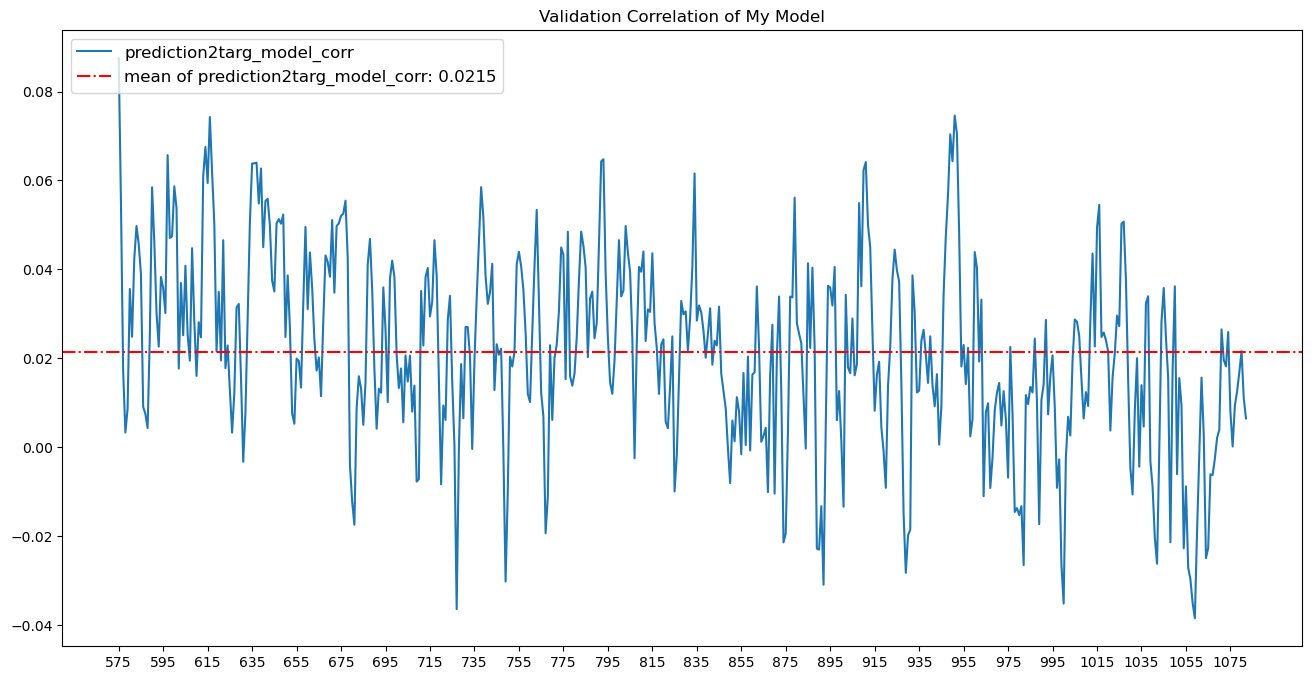

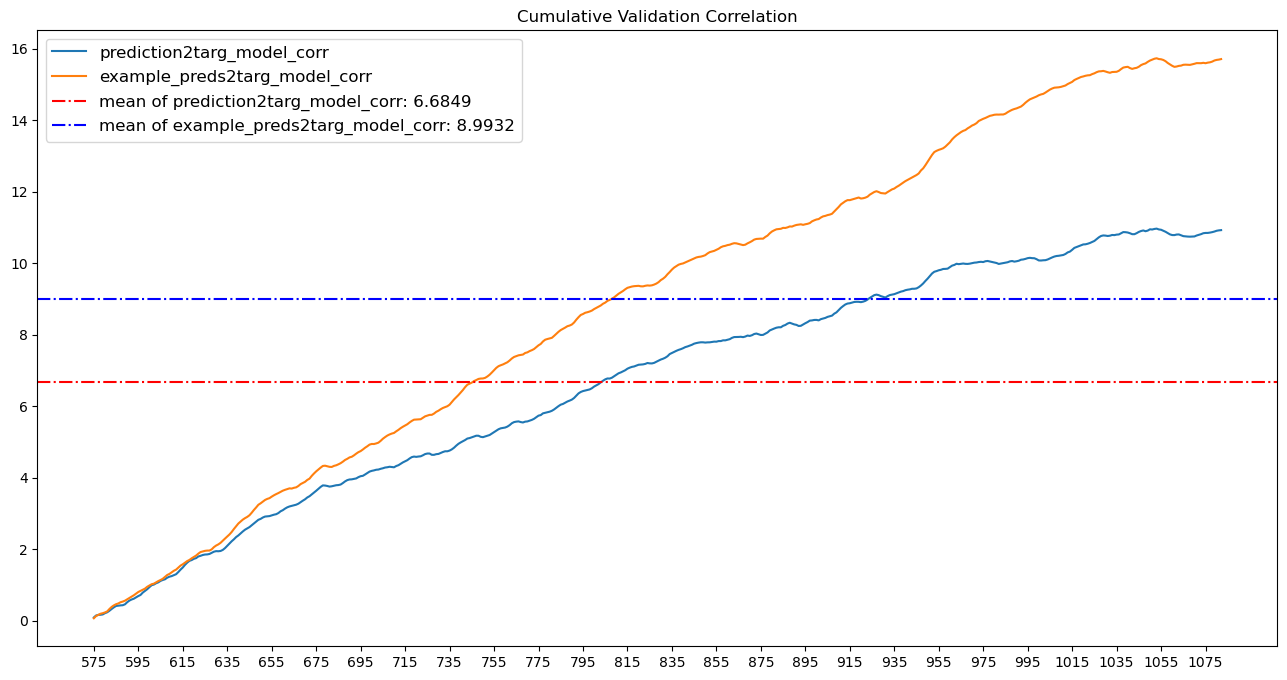

In [15]:
## Evaluating model performance on all val data for `example` and `my model`
evalnumerai.assess_model_performance(nontrain_df, prediction_names[:-1], model_names[:-1], add_means_to_plot=True, plot_cor_my_model=True, file_name_png="all_data_cumsum.png", file_name_csv="all_data_metrics_numerai.csv")

In [16]:
## Adding Meta Model to the mix
diagnosis = nontrain_df[["era_int", MY_MODEL_PREDICTION_NAME, TARGET_NAME, "example_preds"]].reset_index()

# Merge on right which is the meta model df
combined = pd.merge(
    diagnosis,
    meta_model_df,
    on=["id"],
    how="right"
).dropna(axis=0)

Index(['prediction2targ_model_corr', 'example_preds2targ_model_corr',
       'numerai_meta_model2targ_model_corr'],
      dtype='object')


,My_Model,Example_Preds,Meta_Model
mean,0.013406,0.024143,0.016004
min,-0.038398,-0.050413,-0.043135
max,0.074593,0.097112,0.081236
std,0.022272,0.025093,0.021791
sharpe,0.601926,0.962139,0.734418
max_drawdown,0.224978,0.240087,0.182124


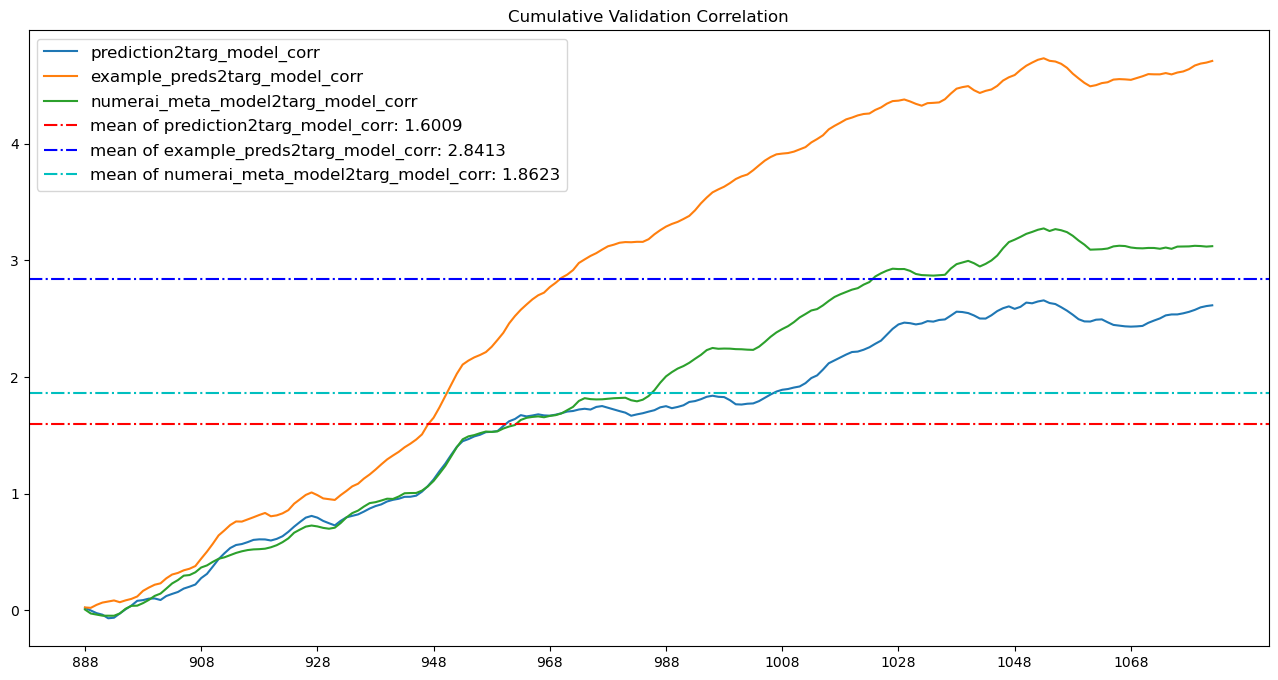

In [17]:
## Evaluating model performance on truncated data for `example`, `my model` and `meta model`
evalnumerai.assess_model_performance(combined, prediction_names, model_names, add_means_to_plot=True, plot_cor_my_model=False, file_name_png="all_models_cumsum.png", file_name_csv="all_models_metrics_numerai.csv")